In [1]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as  np
import pandas  as pd
import sys
from numpy.lib.stride_tricks import sliding_window_view
from multiprocessing import Pool

class TimeData():    
    dim = 0 # dimention  of state
    N = 0 # number of time series data
    num_data = np.array([],dtype = int) # time length of each data 
    x_data = [] # main time series data
    y_data = [] # time series label data
    id_data = [] # non time-series label data
    
    
    def __init__(self,x_data = None, y_data = None, id_data=None):
        if (x_data is not None) and (y_data is not None) and (id_data is not None):
            self.x_data = x_data
            self.y_data = y_data
            self.id_data = id_data
            self.dim =  x_data[0].shape[1]
            self.N =  len(x_data)
            self.num_data  =  np.array([x_data[i].shape[0] for i in range(self.N)],dtype = int)
            self.doctor()

# show the basic statas
    def show(self):
        print(f' State dimention : {self.dim}')
        print(f' Number of data : {self.N}')
        print(f' Each time length : {self.num_data}')
        print(f' IDs : {np.unique(self.id_data,return_counts=True)}')

    
    def doctor(self):        
        # data number check
        if (len(self.x_data) != self.N) or (len(self.y_data) != self.N) or (len(self.id_data) != self.N):
            print(f'Error : data dimention is not same, x_data :{len(self.x_data)}, y_data :{len(self.y_data)}, id_data :{len(self.id_data)}',file=sys.stderr)
            sys.exit(1)
        for i in range(self.dim):
            # data number check
            if self.x_data[i].shape[1] != self.dim:
                print('Error : state dimention is not same',file=sys.stderr)
                sys.exit(1)            
            # state dimention check            
            if (self.x_data[i].shape[0] != self.num_data[i]) or (self.y_data[i].shape[0] != self.num_data[i]):
                print('Error : num_data is not correct',file=sys.stderr)
                sys.exit(1)            
        return
    
    def read_csv(self,filename):
        df = pd.read_csv(filename,index_col=0)
        self.read_dataframe(df)
            
    def read_dataframe(self,df):
        # Columns check
        DATA_KEYS = ['id','time','label']  #  dataformat of time series  
        state_keys = [key for key in df.keys().values if key not in DATA_KEYS]
        self.dim =  len(state_keys)

        # split by  IDs
        IDs = list(set(df.id.values))
        IDs.sort()
        self.N = len(IDs)
        self.num_data = np.zeros(self.N)
        x_data = []
        y_data = []
        for i in range(self.N):
            id_data = IDs[i]
            df_id = df[df.id == id_data]
            self.num_data[i] = df_id.shape[0]
            x_data.append(df_id[state_keys].values)
            y_data.append(df_id['label'].values)

        self.num_data = self.num_data.astype(int)
        # make id labeling 
        id_data = [ 'control'  if np.count_nonzero(y_data[i] == -1) else 'mix' for i in range(len(y_data))] 
        # make
        self.x_data = x_data.copy()
        self.y_data = y_data.copy()
        self.id_data = id_data.copy()
        # data check
        self.doctor()
        return

    
    def normalization(self):
        # normalization
        x_mean = np.r_[[self.x_data[i] for i in range(self.N)]].reshape(self.num_data.sum(),-1).mean(0)
        x_std = np.r_[[self.x_data[i] for i in range(self.N)]].reshape(self.num_data.sum(),-1).std(0)
        self.x_data = [(self.x_data[i] - x_mean)/x_std for i in range(self.N)]
        return

    def at_id(self,id_label):
        x_tmp =[self.x_data[i] for i in range(self.N) if self.id_data[i] == id_label]
        y_tmp =[self.y_data[i] for i in range(self.N) if self.id_data[i] == id_label]
        id_tmp =  [self.id_data[i] for i in range(self.N) if self.id_data[i] == id_label]
        return TimeData(x_data=x_tmp,y_data = y_tmp, id_data=id_tmp)
    
    def split(self, rate = 0.5):
        # shuffle
        all_data = list(zip(self.x_data,self.y_data,self.id_data))
        np.random.shuffle(all_data)
        # calc thresh number         
        N_thresh = int(self.N * rate)
        x_tmp1,y_tmp1,id_tmp1 =zip(*all_data[:N_thresh])
        x_tmp2,y_tmp2,id_tmp2 =zip(*all_data[N_thresh:])
        return TimeData(x_tmp1,y_tmp1,id_tmp1),TimeData(x_tmp2,y_tmp2,id_tmp2)

    def flatten(self):
        x_data = np.concatenate([self.x_data[i] for i in range(self.N)])
        y_data = np.concatenate([self.y_data[i] for i in range(self.N)])
        return x_data, y_data

    def sliding_window(self,window_size):
        x_samples = np.r_[[sliding_window_view(self.x_data[i],(window_size,self.dim)).squeeze(1) for i in range(self.N)]]
        x_samples = x_samples.reshape(-1,x_samples.shape[2],x_samples.shape[3])
        #label is end point on each window
        y_samples = np.r_[[self.y_data[i][window_size-1:] for i in range(self.N)]]
        y_samples = y_samples.reshape(-1)
        return x_samples, y_samples

    def each_sliding_window(self,window_size):
        x_samples = [sliding_window_view(self.x_data[i],(window_size,self.dim)).squeeze(1) for i in range(self.N)]
        #label is end point on each window
        y_samples = [self.y_data[i][window_size-1:] for i in range(self.N)]
        return x_samples, y_samples

    def map_time_series(self, func, multi_core = 1):
        if multi_core <= 1:
            result = [func(self.x_data[i]) for i in range(self.N)]
        else:
            with Pool(multi_core) as p:
                result = p.map(func, self.x_data)
        return result
    
    def map_sliding_window(self,window_size,func,padding = 'same',multi_core = 1):
        x_samples = [sliding_window_view(self.x_data[i],(window_size,self.dim)).squeeze(1) for i in range(self.N)]
        if padding == 'same':
            x_samples = [np.r_[x_samples[i][0,np.newaxis] * np.ones((window_size-1,1,1)),x_samples[i]] for i in range(self.N)]
        elif padding is None:
            pass
        else:
            print("Error: padding_type is incorrect")
            sys.exit(1)
            
        if  multi_core <= 1:
            y_predict = [func(x_samples[i]) for i in range(self.N)]
        else:
            with Pool(multi_core) as p:
                y_predict = p.map(func, x_samples)
        return y_predict
    
    def evaluate_chage_point(self,change_point):
        y_predict = np.concatenate([np.concatenate([np.ones(change_point[i]),np.zeros(self.num_data[i] - change_point[i])]) for i in range(self.N)])
        _,y_test = self.flatten()
 
        TP = (y_predict== 1) & (y_test == 1)
        TN = (y_predict== 0) & (y_test == 0)
        FP = (y_predict== 1) & (y_test == 0)
        FN = (y_predict== 0) & (y_test == 1)
        precision = TP.sum() /(TP.sum() +FP.sum())
        recall = TN.sum() /(TN.sum() +FN.sum())
        F1 =  2*precision*recall/(precision + recall)
        df = pd.DataFrame({'precision':[precision],'recall':[recall],'f1_score':[F1]})
        return df
        
        

In [3]:
df = pd.read_csv('result.csv',index_col=0)

filnames = list(set(df.data))
filnames

['data/toy_ARmodel_change_lnt.csv',
 'data/saddle_node_bifurcation_lnt.csv',
 'data/toy_std_change_lnt.csv',
 'data/toy_structure_change_lnt.csv',
 'data/toy_linear_change_lnt.csv',
 'data/toy_mean_change_lnt.csv',
 'data/mult_saddle_node_bifurcation_lnt.csv']

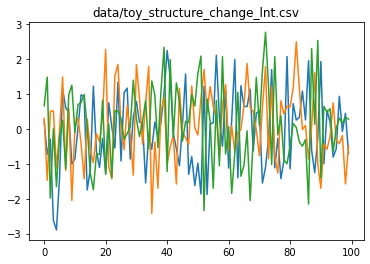

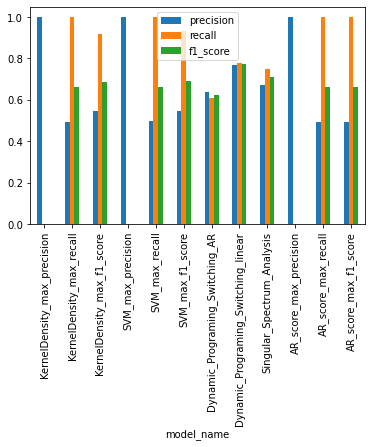

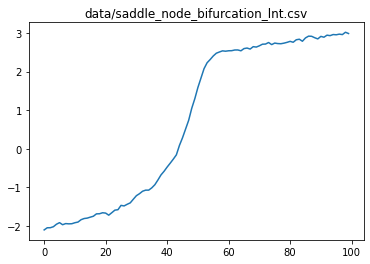

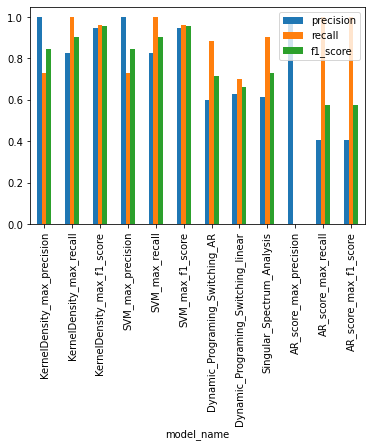

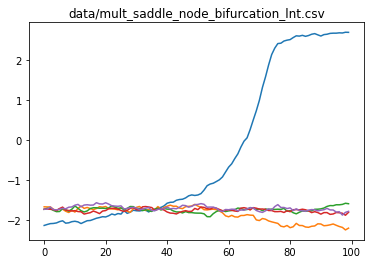

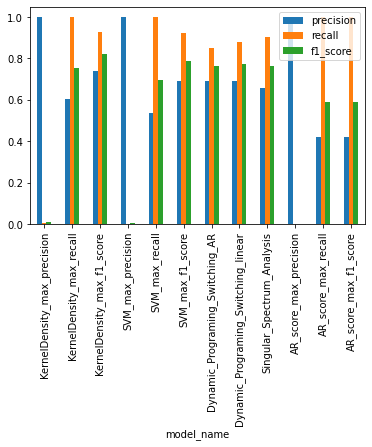

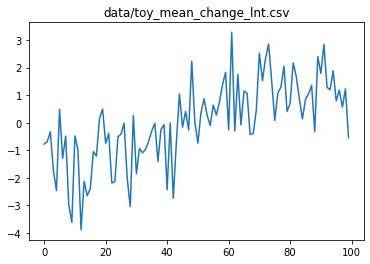

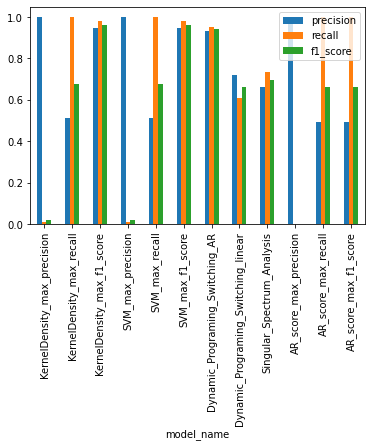

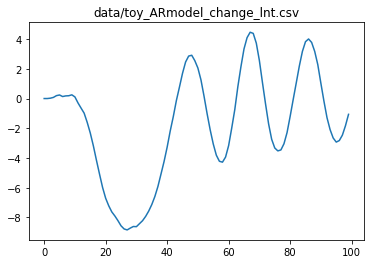

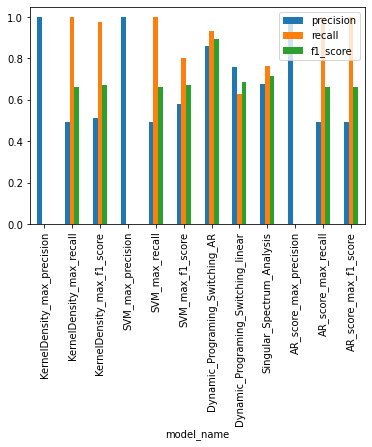

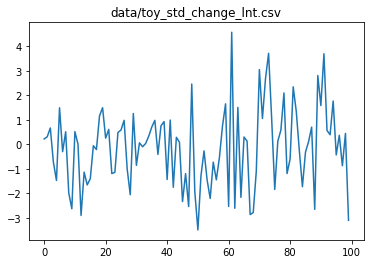

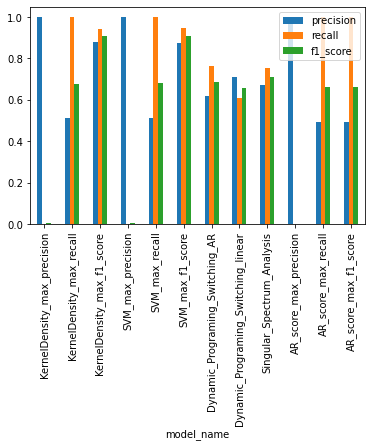

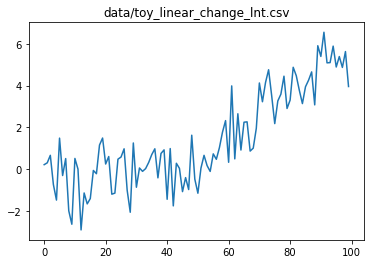

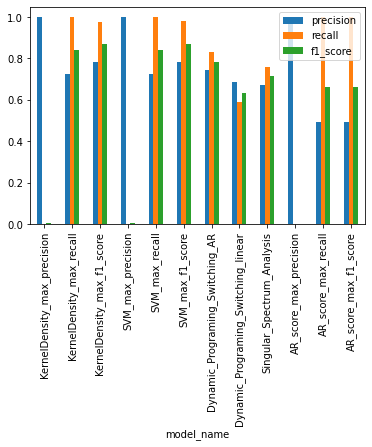

In [42]:

for filename in filnames:
    dt = TimeData()
    dt.read_csv(filename)
    dt_test =  dt.at_id('mix')
    df_test= df[df.data == filename]
    plt.title(filename)
    plt.plot(dt_test.x_data[0])
    df_test.plot.bar(x =  'model_name',y = ['precision','recall','f1_score'])
    plt.savefig('figure/' + filename.split('/')[-1].split('.')[0] + '.png')
    plt.show()


In [80]:
model_name_f1 = [tmp for tmp in list(set(df.model_name))  if  ('max_recall' not in tmp) and ('max_precision' not in tmp)]
data = df.f1_score.values
datas = df.data.value_counts().keys()
models = df.model_name.value_counts().keys()
df_f1 =  pd.DataFrame(data.reshape(datas.shape[0],-1),columns= models,index = datas)
df_f1[model_name_f1]


,Dynamic_Programing_Switching_linear,Dynamic_Programing_Switching_AR,Singular_Spectrum_Analysis,KernelDensity_max_f1_score,SVM_max_f1_score,AR_score_max_f1_score
data/mult_saddle_node_bifurcation_lnt.csv,0.773791,0.760692,0.762082,0.821250,0.789132,0.590253
data/saddle_node_bifurcation_lnt.csv,0.661203,0.713254,0.729271,0.955305,0.955305,0.576587
data/toy_ARmodel_change_lnt.csv,0.687904,0.895773,0.715991,0.672621,0.673126,0.661294
data/toy_linear_change_lnt.csv,0.634940,0.784626,0.713228,0.868643,0.869512,0.661289
data/toy_mean_change_lnt.csv,0.661120,0.942592,0.695597,0.963083,0.963282,0.661285
data/toy_std_change_lnt.csv,0.656876,0.683563,0.708760,0.909871,0.909988,0.661294
data/toy_structure_change_lnt.csv,0.772789,0.624271,0.707973,0.685272,0.689829,0.661289
